In [1]:
import pyabc
import os
import matplotlib.pyplot as plt
from study_abc_noise.model import HodgkinHuxleyModelVars as ModelVars


mv = ModelVars()


#db_files = [f for f in os.listdir('.') if os.path.isfile(f) and ".db" in f]
#print(f"Using db files {db_files}")

db_files = []
for i in [3, 10, 30]:
    for method in ['noisymodel', 'stochacc']:
        db_files.append(f'hh_{i}_{method}.db')

histories = []
labels = []
for db_file in db_files:
    id_ = db_file[3:-3]
    print(db_file)
    h = pyabc.History("sqlite:///" + db_file)
    h.id = 1
    histories.append(h)
    labels.append(id_)


#gt_par = h.get_population(t=-1).get_list()[0].parameter
gt_par = mv.p_true

pyabc.visualization.plot_total_sample_numbers(histories, labels, rotation=45, yscale='log10')
plt.savefig("samples.png")
pyabc.visualization.plot_epsilons(histories, labels, scale="log10")
plt.savefig("epsilons.png")
for h, label in zip(histories, labels):
    pyabc.visualization.plot_histogram_matrix(h)
    plt.savefig(f"hist_{label}.png")
    #for t in range(h.max_t + 1):
    df, w = h.get_distribution()
    pyabc.visualization.plot_kde_matrix(df, w, refval=gt_par, limits=mv.limits)
    plt.savefig(f"kde_{label}.png")
    #plt.close()
pyabc.visualization.plot_effective_sample_sizes(histories, labels, rotation=45)
plt.savefig("ess.png")


hh_3_noisymodel.db
hh_3_stochacc.db
hh_10_noisymodel.db
hh_10_stochacc.db
hh_30_noisymodel.db
hh_30_stochacc.db


3 19084 4959 6886.927036437548 5.901960346438297 6.2303812210479546 1.388773348747237
10 38388 14169 42109.50078607775 19.67872049596867 20.76793740349318 2.9719458526415234
30 63015 10360 898347095.6950853 50.93345265388788 62.303812210479535 86713.04012500824
100 45630 4748 6.315266735990122e+23 161.34242565840964 207.6793740349318 1.330089876998762e+20
300 59097 4729 4.619908858972939e+72 464.183089474464 623.0381221047954 9.769314567504628e+68
1000 71719 4548 3.688794239408523e+231 1552.0137270822975 2076.793740349317 8.110805275744335e+227


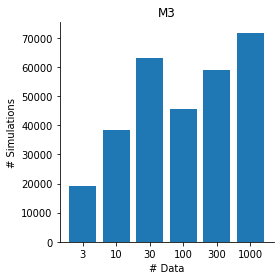

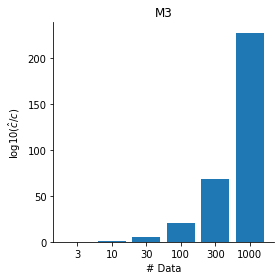

In [2]:
import pickle
import numpy as np

factors = []
arr_n_t = [3,10,30,100,300,1000]
n_d = len(arr_n_t)
arr_total_samples_assa = []


for n_t in arr_n_t:
    mv = ModelVars(n_t=n_t)
    kernel = mv.get_kernel()
    data = pickle.load(open(f"data/data_{n_t}.p", 'rb'))[1]
    kernel.initialize(0, None, data)
    # the (too high) maximum density
    c_hat = kernel.pdf_max
    
    log_file = f"log/log_acceptor_hh_{n_t}_stochacc.json"
    df = pyabc.storage.load_dict_from_json(log_file)
    # the last (highest) used adaptive c (could be computed by optimization)
    c = df[max(df.keys())]
    
    h = pyabc.History(f"sqlite:///hh_{n_t}_stochacc.db", create=False)
    # number of samples in the last iteration
    samples = np.array(h.get_all_populations()['samples'])[-1]
    total_samples = sum(h.get_all_populations()['samples'])
    arr_total_samples_assa.append(total_samples)
    
    factor = np.exp(c_hat - c)
    factors.append(factor)
    
    samples_prediction = np.exp(c_hat - c) * samples
    print(n_t, total_samples, samples, samples_prediction, c, c_hat, samples_prediction / samples)
    
fig, ax = plt.subplots()
ax.bar(np.arange(n_d), arr_total_samples_assa)
ax.set_xticks(np.arange(n_d))
ax.set_xticklabels(arr_n_t)
ax.set_xlabel("# Data")
ax.set_ylabel("# Simulations")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("M3")
fig.set_size_inches((4,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"hh_datapoint_scaling_samples.{fmt}", format=fmt)
    
fig, ax = plt.subplots()
ax.bar(np.arange(n_d), np.log10(factors))
ax.set_xticks(np.arange(n_d))
ax.set_xticklabels(arr_n_t)
ax.set_xlabel("# Data")
ax.set_ylabel("log10($\hat c / c$)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("M3")
fig.set_size_inches((4,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"hh_datapoint_scaling.{fmt}", format=fmt)

# Only consider the use case with 100 dp

In [4]:
import pyabc
import os
import matplotlib.pyplot as plt
from study_abc_noise.model import HodgkinHuxleyModelVars as ModelVars


mv = ModelVars()


#db_files = [f for f in os.listdir('.') if os.path.isfile(f) and ".db" in f]
#print(f"Using db files {db_files}")

db_files = []
for i in [30]:
    for method in ['noisymodel', 'stochacc']:
        db_files.append(f'hh_{i}_{method}.db')

histories = []
labels = []
for db_file in db_files:
    id_ = db_file[3:-3]
    print(db_file)
    h = pyabc.History("sqlite:///" + db_file)
    h.id = 1
    histories.append(h)
    labels.append(id_)

hh_30_noisymodel.db
hh_30_stochacc.db


In [17]:
from scipy.stats import ks_2samp

h_noisy = pyabc.History("sqlite:///hh_3_noisymodel.db")
h_stochacc = pyabc.History("sqlite:///hh_3_stochacc.db")

df, w = h_stochacc.get_distribution()
pars = df.to_dict('records')
resampled = pyabc.weighted_statistics.resample_deterministic(pars, w, 10 * len(w), enforce_n=True)

for t in range(h_noisy.max_t + 1):
    df_t, w_t = h_noisy.get_distribution(t=t)
    pars_t = df_t.to_dict('records')
    resampled_t = pyabc.weighted_statistics.resample_deterministic(pars_t, w_t, 10 * len(w_t), enforce_n=True)
    
    for p in resampled[0]:
        resampled_p = [par[p] for par in resampled]
        resampled_t_p = [par[p] for par in resampled_t]
        _, pv = ks_2samp(resampled_p, resampled_t_p)
        print(pv)

7.532337329002623e-143
0.00033206488074582195
4.28078084174734e-56
1.4654857801998744e-10
7.793436830357318e-37
5.872732802166469e-23
1.8359600584097988e-20
5.063023320273575e-10
8.083148109530224e-10
3.8147229939069957e-10
2.3703390753039754e-10
9.044370890233839e-23
0.00012589922674927242
1.5629151990010467e-08
0.0027063626279497438
1.4333339043460187e-08
1.0322894522731348e-13
0.0541006396905892
8.269286120396377e-14
3.723410418903642e-05


This is not informative or fit as a selection criterion. :( It seems like the posteriors generated do not hold up to a KS test.

hh_30_noisymodel.db
hh_30_stochacc.db


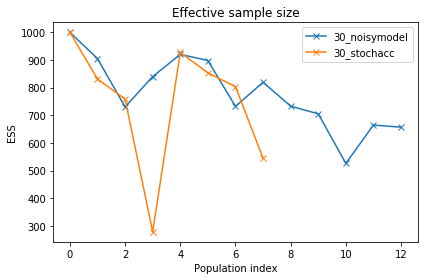

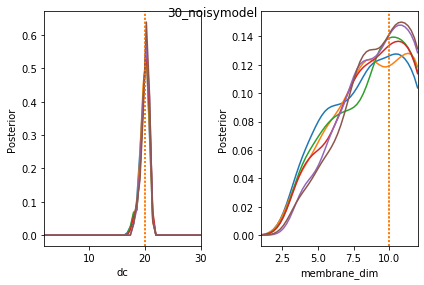

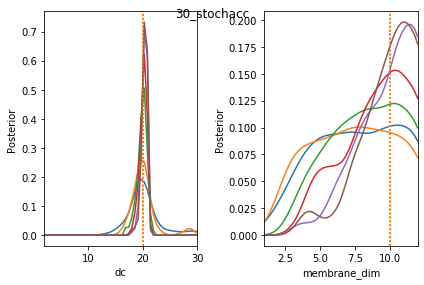

In [27]:
pyabc.visualization.plot_effective_sample_sizes(histories, labels)

for (h, l) in zip(histories, labels):
    _, arr_ax = plt.subplots(1,2)
    for i, p in enumerate(mv.p_true):
        for t in range(h.max_t - 5, h.max_t + 1):
            pyabc.visualization.plot_kde_1d_highlevel(
                h, x=p, t=t, ax=arr_ax[i], refval=mv.p_true, xmin=mv.limits[p][0], xmax=mv.limits[p][1])
    plt.suptitle(l)
    plt.gcf().tight_layout()

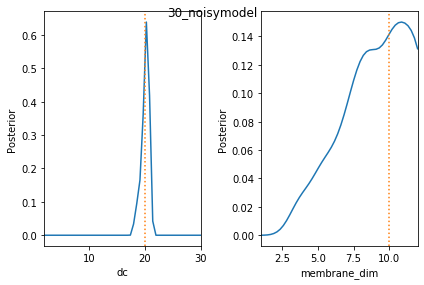

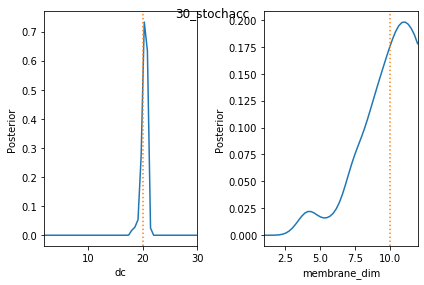

In [35]:
for (h, l, t) in zip(histories, labels, [12, None]):
    _, arr_ax = plt.subplots(1,2)
    for i, p in enumerate(mv.p_true):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, t=t, ax=arr_ax[i], refval=mv.p_true, xmin=mv.limits[p][0], xmax=mv.limits[p][1])
    plt.suptitle(l)
    plt.gcf().tight_layout()

{0: [4.3957100798708], 1: [3.30336063967205, 2.1978550399354], 2: [2.7054226367151206, 1.0989275199677], 3: [2.2321626938662726, 0.54946375998385], 4: [2.2322653033901103, 0.5]}
[4.3957100798708, 3.30336063967205, 2.7054226367151206, 2.2321626938662726] [2.1978550399354, 1.0989275199677, 0.54946375998385]
{0: [10.212006280925705], 1: [6.123676363962525, 5.106003140462852], 2: [6.074633177749642, 2.553001570231426], 3: [4.381890808504153, 1.276500785115713], 4: [4.26437544405793, 0.6382503925578565], 5: [3.843485003870754, 0.5]}
[10.212006280925705, 6.123676363962525, 6.074633177749642, 4.381890808504153, 4.26437544405793] [5.106003140462852, 2.553001570231426, 1.276500785115713, 0.6382503925578565]
{0: [74.91729918040635], 1: [64.40332610210717, 37.45864959020317], 2: [50.60669663278261, 18.729324795101586], 3: [29.165267949054886, 9.364662397550793], 4: [21.053337868305523, 4.682331198775397], 5: [7.6737145675303085, 2.3411655993876983], 6: [5.255954193275938, 1.1705827996938492], 7: 

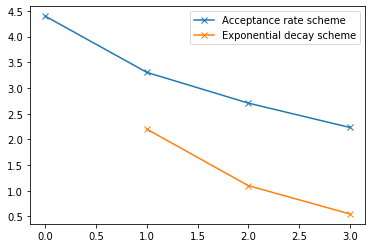

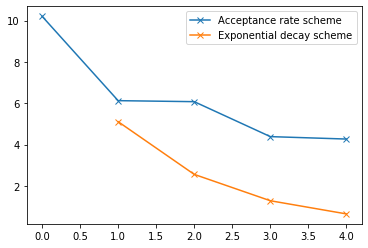

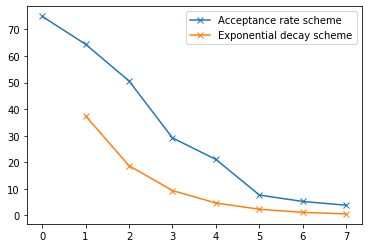

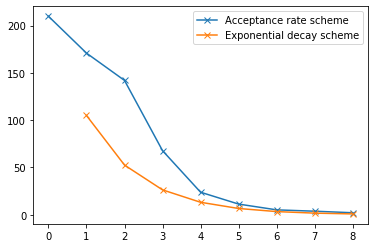

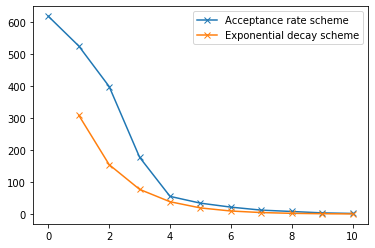

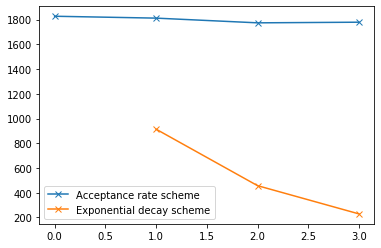

In [8]:
for n_t in [3,10,30,100,300,1000]:

    t_dct = pyabc.storage.load_dict_from_json(f"log/log_temperature_hh_{n_t}_stochacc.json")
    print(t_dct)

    ts_accrate = np.arange(max(t_dct))
    ts_decay = np.arange(1, max(t_dct))

    vals_accrate = [t_dct[t][0] for t in ts_accrate]
    vals_decay = [t_dct[t][1] for t in ts_decay]

    print(vals_accrate, vals_decay)

    fig, ax = plt.subplots()
    ax.plot(ts_accrate,vals_accrate, 'x-', label='Acceptance rate scheme')
    ax.plot(ts_decay, vals_decay, 'x-', label='Exponential decay scheme')
    ax.legend()
